<a href="https://colab.research.google.com/github/shekhar5908/AI-tools/blob/main/nmt2_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import random
from fastai.vision.all import *
from fastai.text.all import *
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision


from collections import Counter     # for tokenizer

import torchvision.transforms as T
import torchvision.models as models
import torch
import torchvision.transforms as transforms
from PIL import Image


import matplotlib.pyplot as plt
# import matplotlib.image as Image
import PIL
from PIL import Image

# for the bleu scores
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

import sentencepiece as spm
import tempfile


import shutil


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)




In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
English_captions_path = "/content/drive/MyDrive/final_project/captions.txt"
Hindi_captions_path = "/content/drive/MyDrive/final_project/UnClean-5Sentences_withComma.txt"
images_path = "/content/drive/MyDrive/final_project/Images"

# Data preprocessing

In [ ]:
# READ THE CAPTIONS FILE.txt
df_english = pd.read_csv(English_captions_path)

print(f"No of captions: {len(df_english)}")
df_english.head()

No of captions: 40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# READ THE CAPTIONS FILE.txt
df_hindi = pd.read_csv(Hindi_captions_path)

print(f"No of captions: {len(df_hindi)}")
df_hindi.head()

No of captions: 40450


,image,caption
0,1000268201_693b08cb0e,गुलाबी पोशाक में एक बच्चा प्रवेश के रास्ते में सीढ़ियों के एक सेट पर चढ़ रहा है।
1,1000268201_693b08cb0e,एक लड़की लकड़ी की इमारत में जा रही है।
2,1000268201_693b08cb0e,एक छोटी लड़की लकड़ी के प्लेहाउस में चढ़ गई।
3,1000268201_693b08cb0e,एक छोटी सी लड़की अपने प्लेहाउस में सीढ़ियाँ चढ़ रही थी।
4,1000268201_693b08cb0e,एक गुलाबी पोशाक में एक छोटी लड़की एक लकड़ी के केबिन में जा रही है।


Number of images in the folder: 8091


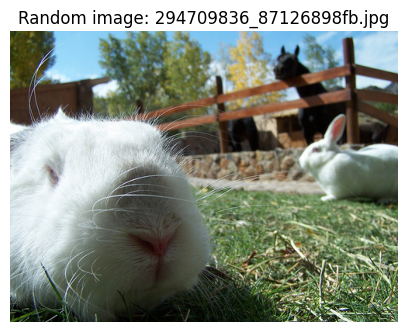

In [ ]:


from PIL import Image



# Count the number of images in the folder
image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
image_count = len(image_files)

print(f"Number of images in the folder: {image_count}")

# Display a random image from the folder
if image_count > 0:
    # Choose a random image
    random_image = random.choice(image_files)
    image_path = os.path.join(images_path, random_image)

    # Open and display the image
    img = Image.open(image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Random image: {random_image}")
    plt.show()
else:
    print("No images found in the specified folder.")

## now , here it come a first problem, count of images are 8091 and each images are related to 5 caption sentences, where in English captions count is correct i.e. 40455 but Hindi captions count are 40450, its mean that one image is missing its Hindi captions

In [ ]:
print(df_english)

                           image                                                                      caption
0      1000268201_693b08cb0e.jpg     A child in a pink dress is climbing up a set of stairs in an entry way .
1      1000268201_693b08cb0e.jpg                                        A girl going into a wooden building .
2      1000268201_693b08cb0e.jpg                             A little girl climbing into a wooden playhouse .
3      1000268201_693b08cb0e.jpg                         A little girl climbing the stairs to her playhouse .
4      1000268201_693b08cb0e.jpg                    A little girl in a pink dress going into a wooden cabin .
...                          ...                                                                          ...
40450   997722733_0cb5439472.jpg                                     A man in a pink shirt climbs a rock face
40451   997722733_0cb5439472.jpg                                     A man is rock climbing high in the air .
40452   99

In [ ]:
print(df_hindi)

                       image                                                                                caption
0      1000268201_693b08cb0e       गुलाबी पोशाक में एक बच्चा प्रवेश के रास्ते में सीढ़ियों के एक सेट पर चढ़ रहा है।
1      1000268201_693b08cb0e                                                 एक लड़की लकड़ी की इमारत में जा रही है।
2      1000268201_693b08cb0e                                            एक छोटी लड़की लकड़ी के प्लेहाउस में चढ़ गई।
3      1000268201_693b08cb0e                                एक छोटी सी लड़की अपने प्लेहाउस में सीढ़ियाँ चढ़ रही थी।
4      1000268201_693b08cb0e                     एक गुलाबी पोशाक में एक छोटी लड़की एक लकड़ी के केबिन में जा रही है।
...                      ...                                                                                    ...
40445   997722733_0cb5439472                                    एक गुलाबी शर्ट में एक आदमी एक रॉक चेहरे पर चढ़ता है
40446   997722733_0cb5439472                                            

 ## Firstly add .jpg in hindi dataset image column

In [ ]:
# Add '.jpg' to the 'image' column
df_hindi['image'] = df_hindi['image'] + '.jpg'

In [ ]:
df_hindi

,image,caption
0,1000268201_693b08cb0e.jpg,गुलाबी पोशाक में एक बच्चा प्रवेश के रास्ते में सीढ़ियों के एक सेट पर चढ़ रहा है।
1,1000268201_693b08cb0e.jpg,एक लड़की लकड़ी की इमारत में जा रही है।
2,1000268201_693b08cb0e.jpg,एक छोटी लड़की लकड़ी के प्लेहाउस में चढ़ गई।
3,1000268201_693b08cb0e.jpg,एक छोटी सी लड़की अपने प्लेहाउस में सीढ़ियाँ चढ़ रही थी।
4,1000268201_693b08cb0e.jpg,एक गुलाबी पोशाक में एक छोटी लड़की एक लकड़ी के केबिन में जा रही है।
...,...,...
40445,997722733_0cb5439472.jpg,एक गुलाबी शर्ट में एक आदमी एक रॉक चेहरे पर चढ़ता है
40446,997722733_0cb5439472.jpg,एक आदमी हवा में ऊंची चढ़ाई कर रहा है।
40447,997722733_0cb5439472.jpg,एक लाल रंग की शर्ट में एक व्यक्ति असिस्ट हैंडल में ढंके हुए एक चट्टान के ऊपर चढ़ गया।
40448,997722733_0cb5439472.jpg,लाल शर्ट में एक रॉक क्लाइंबर।


## Compare the 'image' columns of df_hindi and df_english to find missing values in df_hindi

In [ ]:
# Get unique image names from both datasets
english_images = set(df_english['image'].unique())
hindi_images = set(df_hindi['image'].unique())

# Find missing images in Hindi dataset
missing_images = english_images - hindi_images

if missing_images:
    print("Images missing in Hindi dataset:")
    for img in missing_images:
        print(img)
    print(f"\nTotal missing images: {len(missing_images)}")
else:
    print("No images are missing in the Hindi dataset.")

# Check if there are any images in Hindi dataset not present in English dataset
extra_images_hindi = hindi_images - english_images
if extra_images_hindi:
    print("\nImages in Hindi dataset not present in English dataset:")
    for img in extra_images_hindi:
        print(img)
    print(f"\nTotal extra images in Hindi dataset: {len(extra_images_hindi)}")
else:
    print("\nNo extra images in Hindi dataset.")

# Verify the count of captions
print(f"\nTotal English captions: {len(df_english)}")
print(f"Total Hindi captions: {len(df_hindi)}")
print(f"Difference: {len(df_english) - len(df_hindi)}")

# If there are missing images, show their English captions
if missing_images:
    print("\nEnglish captions for the missing images:")
    missing_captions = df_english[df_english['image'].isin(missing_images)]
    print(missing_captions)


Images missing in Hindi dataset:
145721498_a27d2db576.jpg

Total missing images: 1

No extra images in Hindi dataset.

Total English captions: 40455
Total Hindi captions: 40450
Difference: 5

English captions for the missing images:
                         image                                                 caption
2430  145721498_a27d2db576.jpg      A man in a blue canoe battling through rough waves
2431  145721498_a27d2db576.jpg                      A man kayaks through rough water .
2432  145721498_a27d2db576.jpg    A man rows a blue kayak through white water rapids .
2433  145721498_a27d2db576.jpg               Man paddling in blue kayak in the water .
2434  145721498_a27d2db576.jpg  The kayaker braces himself as he goes down the river .


In [ ]:
# Identify the image to be removed
image_to_remove = '145721498_a27d2db576.jpg'

# Remove rows with the identified image
df_english = df_english[df_english['image'] != image_to_remove]

# Reset the index of df_english
df_english = df_english.reset_index(drop=True)

# Verify the removal
print(f"Total English captions after removal: {len(df_english)}")
print(f"Total Hindi captions: {len(df_hindi)}")
print(f"Difference: {len(df_english) - len(df_hindi)}")

# Check if the image has been removed
if image_to_remove not in df_english['image'].values:
    print(f"\nThe image {image_to_remove} has been successfully removed from df_english.")
else:
    print(f"\nError: The image {image_to_remove} is still present in df_english.")

# Optional: Save the updated df_english to a new CSV file if needed
# df_english.to_csv("/content/drive/MyDrive/final_project/updated_english_captions.txt", index=False)


Total English captions after removal: 40450
Total Hindi captions: 40450
Difference: 0

The image 145721498_a27d2db576.jpg has been successfully removed from df_english.


In [ ]:
# Drop the 'image' column
w1 = df_english.drop('image', axis=1)
w2 = df_hindi.drop('image', axis=1)
print(w1[:5])
print(w2[:5])

                                                                    caption
0  A child in a pink dress is climbing up a set of stairs in an entry way .
1                                     A girl going into a wooden building .
2                          A little girl climbing into a wooden playhouse .
3                      A little girl climbing the stairs to her playhouse .
4                 A little girl in a pink dress going into a wooden cabin .
                                                                            caption
0  गुलाबी पोशाक में एक बच्चा प्रवेश के रास्ते में सीढ़ियों के एक सेट पर चढ़ रहा है।
1                                            एक लड़की लकड़ी की इमारत में जा रही है।
2                                       एक छोटी लड़की लकड़ी के प्लेहाउस में चढ़ गई।
3                           एक छोटी सी लड़की अपने प्लेहाउस में सीढ़ियाँ चढ़ रही थी।
4                एक गुलाबी पोशाक में एक छोटी लड़की एक लकड़ी के केबिन में जा रही है।



Once we have loaded the dataset, we preprocess the data as follows:

Add a start and end token to each sentence.

Clean the sentences by removing special characters.

Create a word index and reverse word index (dictionaries mapping from word → id and id → word).

Pad each sentence to a maximum length.

In [ ]:
print(type(w1))
print(type(w2))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Restrict the total number of sentences to 70000
NUM_SENTENCES = 10000

In [ ]:
!pip install indic-nlp-library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.8 MB/s eta 0:00:00
  Attempting uninstall: Pygments
    Found existing installation: Pygments 2.16.1
    Uninstalling Pygments-2.16.1:
      Successfully uninstalled Pygments-2.16.1
  Attempting uninstall: docutils
    Found existing installation: docutils 0.18.1
    Uninstalling docutils-0.18.1:
      Successfully uninstalled docutils-0.18.1
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 5.0.2
    Uninstalling Sphinx-5.0.2:
      Successfully uninstalled Sphinx-5.0.2
ERROR: pip's dependency resolver does not currently 

In [ ]:
from indicnlp.tokenize import indic_tokenize

# Define the number of sentences to process (you can adjust this as needed)
NUM_SENTENCES = 10000

# Initialize lists to hold the cleaned and tokenized sentences
input_sentences = []
output_sentences = []

# Process the English input sentences from w1
for i, row in w1.iterrows():
    if i >= NUM_SENTENCES:
        break
    input_sentence = row['caption'].strip().strip("\n").strip('-')  # Strip unnecessary characters
    input_sentences.append(input_sentence)

# Process the Hindi output sentences from w2
for i, row in w2.iterrows():
    if i >= NUM_SENTENCES:
        break
    output_sentence = row['caption'].strip().strip("\n").strip('-')
    tokenized_sentence = indic_tokenize.trivial_tokenize(output_sentence)  # Tokenize Hindi sentences
    output_sentences.append(['<sos>'] + tokenized_sentence + ['<eos>'])  # Add <sos> and <eos> tags

# Print the type of a sample entry to verify
print(type(input_sentences[10]))  # Expected: <class 'str'>
print(type(output_sentences[10]))  # Expected: <class 'list'>


<class 'str'>
<class 'list'>


In [ ]:
print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))

num samples input: 10000
num samples output: 10000


In [ ]:
print(input_sentences[-1])
print(output_sentences[-1])

The boy is playing with a colorful ribbon .
['<sos>', 'लड़का', 'एक', 'रंगीन', 'रिबन', 'के', 'साथ', 'खेल', 'रहा', 'है', '।', '<eos>']


In [ ]:
# Converts the unicode file to ascii
# Since the model is dealing with multilingual text so it will be important to standardize the input text.
# Unicode normalization splits accented characters and replace compatibility characters with their ASCII equivalents.
# https://bit.ly/2TnLffX
import unicodedata
import re
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."

  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<sos> ' + w + ' <eos>'
  return w

In [ ]:
for i in range(len(input_sentences)):
   input_sentences[i] = preprocess_sentence(input_sentences[i])

print(input_sentences[8])
print(output_sentences[8])

<sos> two dogs of different breeds looking at each other on the road . <eos>
['<sos>', 'सड़क', 'पर', 'एक', '-', 'दूसरे', 'को', 'देख', 'अलग', '-', 'अलग', 'नस्लों', 'के', 'दो', 'कुत्ते', '।', '<eos>']


In [ ]:
# function to tokenize, fit the words into numeric sequences and pad them with zeroes up to the size of the largest sentence of that vocabulary
# takes as input the input / output vocabulary and the padding type ('pre' / 'post'-- default: post)

# inp_lang and targ_lang is of type tokenizer.fit_on_texts;
# fit_on_texts of Tokenizer class updates internal vocabulary based on a list of texts.
# This method creates the vocabulary index based on word frequency.
# Lower integer means more frequent word (often the first few are stop words because they appear a lot).

import tensorflow as tf

def tokenize(lang, pad):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')

  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  return tensor, lang_tokenizer

In [ ]:
# function to call the tokenize function to perform tokenizing and padding

def load_dataset(inp_lang, targ_lang):
  # creating cleaned input, output pairs
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang, 'post')
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang, 'post')

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(input_sentences, output_sentences)

# Calculate max_length of the target tensors
# For our project, the max_length_targ and max_length_inp are 45 and 40 respectively.

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_targ)
print(max_length_inp)

42
40


In [ ]:
# checking if the input sequences have been obtained and padded properly
print(target_tensor[9])
print(input_tensor[9])

[   2  165    8   17   22    1   90   11   74 1278   24    4    3    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
[  2  14  33   7 647 721 357 131  87   4   3   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]


In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=7)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

8000 8000 2000 2000


In [ ]:
# checking if the input sequences have been obtained and padded properly
print(input_tensor_val[9])
print(target_tensor_val[9])

[  2   1  22  99   7   1 191  62  82   1  67 267   6   5  24   4   3   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
[  2   1  28  27   7   1 317 280 108   1 241  52  64   8 218   5   4   3
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


In [ ]:
# a function to test if the word to index / index to word mappings have been obtained correctly.
# representative output for two sample english and hindi sentences given in the code block below

def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
      print ("%s ----> %d" % (lang.index_word[t], lang.word_index[lang.index_word[t]]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
2 ----> <sos>
<sos> ----> 2
5 ----> the
the ----> 5
12 ----> man
man ----> 12
262 ----> wears
wears ----> 262
1 ----> a
a ----> 1
57 ----> green
green ----> 57
83 ----> hat
hat ----> 83
10 ----> and
and ----> 10
77 ----> jacket
jacket ----> 77
43 ----> while
while ----> 43
40 ----> standing
standing ----> 40
6 ----> in
in ----> 6
50 ----> front
front ----> 50
13 ----> of
of ----> 13
1 ----> a
a ----> 1
104 ----> mountain
mountain ----> 104
4 ----> .
. ----> 4
3 ----> <eos>
<eos> ----> 3

Target Language; index to word mapping
2 ----> <sos>
<sos> ----> 2
15 ----> आदमी
आदमी ----> 15
1 ----> एक
एक ----> 1
125 ----> पहाड़
पहाड़ ----> 125
6 ----> के
के ----> 6
54 ----> सामने
सामने ----> 54
81 ----> खड़े
खड़े ----> 81
543 ----> होने
होने ----> 543
6 ----> के
के ----> 6
228 ----> दौरान
दौरान ----> 228
1 ----> एक
एक ----> 1
76 ----> हरे
हरे ----> 76
20 ----> रंग
रंग ----> 20
11 ----> की
की ----> 11
68 ----> टोपी
टोपी ----> 68
9 ----> और
और ----> 9
75 ---->

In [ ]:
# BUFFER_SIZE stores the number of training points
BUFFER_SIZE = len(input_tensor_train)

# BATCH_SIZE is set to 64. Training and gradient descent happens in batches of 64
BATCH_SIZE = 64

# the number of batches in one epoch (also, the number of steps during training, when we go batch by batch)
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE

# the length of the embedded vector
embedding_dim = 256

# no of GRUs
units = 1024

# getting the size of the input and output vocabularies.
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

# now, we shuffle the dataset and split it into batches of 64
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # the remainder after splitting by 64 are dropped

print(BUFFER_SIZE)
print(BUFFER_SIZE//64)
print(steps_per_epoch)

8000
125
125


In [ ]:
# to understand the shape of an input batch
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 40]), TensorShape([64, 42]))

##Encoder-Decoder model
The encoder model consists of an embedding layer, a GRU layer with 1024 units.

The decoder model consists of a embedding layer, a GRU layer and a dense layer.

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz # set batch size
    self.enc_units = enc_units # set the number of GRU units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # set the embedding layer using the input's vocabulary size and the embedding dimension (which is set to 256)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') # define the GRU layer

  def call(self, x, hidden): # this function is invoked when the function encoder is called with an input and an initialised hidden layer
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden) # pass input x into the GRU layer
    return output, state # function returns the encoder output and the hidden state


  def initialize_hidden_state(self): #intialise hidden layer to all zeroes (for determining the shape)
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE) # create an Encoder class object

# sample input to get a sense of the shapes.
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 40, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz # batch_size which is defined as 64
    self.dec_units = dec_units # the number of decoder GRU units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # defining an embedding layer for the target language output.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') # GRU layer
    self.fc = tf.keras.layers.Dense(vocab_size)


  def call(self, x, hidden):

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x) # creating an embedding layer for the target output

    # passing the initial state to the GRU as the hidden state
    output, state = self.gru(x, initial_state=hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output) # pass the output through the dense layer

    return x, state # return decoder output and decoder state

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4826)


#Training the model¶
The model is trained on a GPU machine with fixed number of epochs.

A custom training loop (instead of Model.Fit etc.) is used for which further reference is available from Tensorflow here

The model can be extended with the use of the validation data for early stopping and further fine tuning.

Checkpoints are stored for easy retrival of the model and resue without training

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') #Loss function is categorical crossentropy

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './tutorial_checkpoint_nmt'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<sos>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden = decoder(dec_input, dec_hidden)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables)) # doing gradient descent

  return batch_loss

In [ ]:
train = True
EPOCHS = 10
if train :
  for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step(inp, targ, enc_hidden)
      total_loss += batch_loss

      if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                    batch,
                                                    batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.7673
Epoch 1 Batch 100 Loss 1.4024
Epoch 1 Loss 1.5097
Time taken for 1 epoch 208.78186345100403 sec

Epoch 2 Batch 0 Loss 1.1389
Epoch 2 Batch 100 Loss 0.9927
Epoch 2 Loss 1.1019
Time taken for 1 epoch 174.6262547969818 sec

Epoch 3 Batch 0 Loss 1.0249
Epoch 3 Batch 100 Loss 0.8731
Epoch 3 Loss 0.9426
Time taken for 1 epoch 172.57443523406982 sec

Epoch 4 Batch 0 Loss 0.7211
Epoch 4 Batch 100 Loss 0.8094
Epoch 4 Loss 0.8135
Time taken for 1 epoch 171.9892029762268 sec

Epoch 5 Batch 0 Loss 0.6842
Epoch 5 Batch 100 Loss 0.6989
Epoch 5 Loss 0.6953
Time taken for 1 epoch 172.01560878753662 sec

Epoch 6 Batch 0 Loss 0.5711
Epoch 6 Batch 100 Loss 0.5574
Epoch 6 Loss 0.5811
Time taken for 1 epoch 177.9897859096527 sec

Epoch 7 Batch 0 Loss 0.4112
Epoch 7 Batch 100 Loss 0.4968
Epoch 7 Loss 0.4757
Time taken for 1 epoch 177.04346179962158 sec

Epoch 8 Batch 0 Loss 0.3528
Epoch 8 Batch 100 Loss 0.4039
Epoch 8 Loss 0.3781
Time taken for 1 epoch 177.97491717338562 sec

Epo

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#Prediction using Greedy Search¶
Greedy search is used to for Decoding of text.

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<sos>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input,dec_hidden)

    # pass the encoder output, decoder hidden state(which is initialised to encoder hidden state for the first time and decoder input to the decoder)
    # make a prediction and obtain decoder hidden states

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<eos>':
      return result, sentence

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [ ]:
def translate(sentence):
  result, sentence = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  return result

In [ ]:
# Define preprocess_sentence and translate_with_custom_model functions

def preprocess_sentence(sentence):
    sentence = unicode_to_ascii(sentence.lower().strip())
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<sos> ' + sentence + ' <eos>'
    return sentence

def translate_with_custom_model(caption):
    caption = preprocess_sentence(caption)
    inputs = [inp_lang.word_index.get(i, 0) for i in caption.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<sos>']], 0)

    result = ''
    for t in range(max_length_targ):
        predictions, dec_hidden = decoder(dec_input, dec_hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<eos>':
            return result.strip()

        dec_input = tf.expand_dims([predicted_id], 0)

    return result.strip()


In [ ]:
translate("two dogs of different breeds looking at each other on the road ")

Input: <sos> two dogs of different breeds looking at each other on the road <eos>
Predicted translation: विभिन्न नस्लों के दो कुत्ते एक चरागाह में खड़े हैं जबकि एक कुत्ता उसमें दिखता है । <eos> 


'विभिन्न नस्लों के दो कुत्ते एक चरागाह में खड़े हैं जबकि एक कुत्ता उसमें दिखता है । <eos> '

In [ ]:
translate("The boy is playing with a colorful ribbon")

Input: <sos> the boy is playing with a colorful ribbon <eos>
Predicted translation: लड़का बास्केटबॉल खेल रहा है जबकि बास्केटबॉल खेल रहा है । <eos> 


'लड़का बास्केटबॉल खेल रहा है जबकि बास्केटबॉल खेल रहा है । <eos> '

#Calculating BLEU, BERT, METEOR score for evaluation¶
BLEU score (Bilingual Evaluation Understudy) is calculated on the test data for evaluating the quality of translations

In [ ]:
# Assuming w1 and w2 are the DataFrames containing test data for English and Hindi respectively

# Initialize lists to store processed sentences
test_input_sentences = []
test_output_sentences = []

# Process the English sentences (w1)
for i, row in w1.iterrows():
    test_input_sentence = row['caption'].strip().strip("\n").strip('-')
    test_input_sentences.append(test_input_sentence)

# Process the Hindi sentences (w2)
for i, row in w2.iterrows():
    test_output_sentence = row['caption'].strip().strip("\n").strip('-')
    tokenized_sentence = indic_tokenize.trivial_tokenize(test_output_sentence)
    test_output_sentences.append(['<sos>'] + tokenized_sentence + ['<eos>'])

# Verify the output
print(type(test_input_sentences[90]))  # Should print <class 'str'>
print(len(test_output_sentences))  # Should print the number of sentences processed
print(test_input_sentences[90])  # Sample English sentence
print(test_output_sentences[90])  # Sample tokenized Hindi sentence


<class 'str'>
40450
A black dog running in the surf .
['<sos>', 'सर्फ', 'में', 'एक', 'काला', 'कुत्ता', 'दौड़', 'रहा', 'है', '।', '<eos>']


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction()
evaluate_n_sentences = 10

references = []
candidates = []
for i in range(evaluate_n_sentences):
  try:
    res = translate(test_input_sentences[i])
    ref = test_output_sentences[i].copy()
    ref = [e for e in ref if e not in ('<eos>', '<sos>', '.')]
    references.append(ref)
    listToStr = ' '.join(map(str, test_output_sentences[i]))
    print('Reference Translation: %s' % (listToStr))
    candidate = indic_tokenize.trivial_tokenize(res)
    candidate = [e for e in candidate if e not in ('<', 'eos','>', '.')]
    candidates.append(candidate)
  except:
    print('Sentence :', i+1, ' not translatable ..moving to next' )
score1 = corpus_bleu(references, candidates, smoothing_function=chencherry.method4)
score2 = corpus_bleu(references, candidates)
print('BLEU score on test data without smoothing function: ' ,score2)
print('BLEU score on test data with smoothing function: ' ,score1)

Input: <sos> a child in a pink dress is climbing up a set of stairs in an entry way . <eos>
Predicted translation: एक नीली लेटर्ड में एक बच्चा एक वयस्क द्वारा निर्देशित होता है जबकि एक वयस्क उसके पीछे से दूर होती है । <eos> 
Reference Translation: <sos> गुलाबी पोशाक में एक बच्चा प्रवेश के रास्ते में सीढ़ियों के एक सेट पर चढ़ रहा है । <eos>
Input: <sos> a girl going into a wooden building . <eos>
Predicted translation: एक लड़की एक अच्छे दिन में झूलती है । <eos> 
Reference Translation: <sos> एक लड़की लकड़ी की इमारत में जा रही है । <eos>
Input: <sos> a little girl climbing into a wooden playhouse . <eos>
Predicted translation: एक छोटी लड़की लकड़ी के प्लेहाउस में चढ़ गई । <eos> 
Reference Translation: <sos> एक छोटी लड़की लकड़ी के प्लेहाउस में चढ़ गई । <eos>
Input: <sos> a little girl climbing the stairs to her playhouse . <eos>
Predicted translation: एक छोटी लड़की खुशी से झांकती है । <eos> 
Reference Translation: <sos> एक छोटी सी लड़की अपने प्लेहाउस में सीढ़ियाँ चढ़ रही थी । <eos>
Input: <

In [ ]:
!pip install bert-score
!pip install nltk

In [ ]:
# Your existing imports and code here...

from bert_score import score

# After your existing BLEU score calculation

# Prepare lists for BERT score calculation
cands = [' '.join(candidate) for candidate in candidates]
refs = [' '.join(reference) for reference in references]

# Calculate BERT scores
P, R, F1 = score(cands, refs, lang="hi", verbose=True)

# Print BERT scores
print(f"BERT Precision: {P.mean():.3f}")
print(f"BERT Recall: {R.mean():.3f}")
print(f"BERT F1: {F1.mean():.3f}")

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.53 seconds, 18.83 sentences/sec
BERT Precision: 0.874
BERT Recall: 0.869
BERT F1: 0.871


In [ ]:
from nltk.translate.meteor_score import meteor_score
import nltk
nltk.download('wordnet')  # Required for METEOR

# Assuming candidates and references are already tokenized lists

# Calculate METEOR scores
meteor_scores = [meteor_score([ref], cand) for ref, cand in zip(references, candidates)]

# Print average METEOR score
average_meteor_score = sum(meteor_scores) / len(meteor_scores)
print(f"Average METEOR Score: {average_meteor_score:.3f}")

Average METEOR Score: 0.601


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
